This simulation was created to understand the impact of discharge times on ED wait times. 
For the purpose of this simulation, the patient journey starts after they have been admitted.

Patient journey:
ED patient admitted    --ED wait time-->    left ED time    --length of stay-->    discharged from hospital

At the start of each hour a poisson distrubution is used to generate the number of patients admitted during the hour. The poisson distribution depends on the time of day and the day of week.
Once patients are admitted, they will request a bed or wait until a bed is available.
After a patient has seized a bed, their length of stay and discharge time is randomly chosen based on they day of week.
The patient's bed is held for a hour after dischrage before returning to the pool of available beds.

In [1]:
import simpy
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

### Simulation

In [2]:
class Hospital(object):
    def __init__(self, env, num_beds, admit_rate, length_of_stay_rate, discharge_rate):
        self.env = env
        self.bed = simpy.Resource(env, num_beds)

        self.admit_rate = admit_rate
        self.length_of_stay_rate = length_of_stay_rate
        self.discharge_rate = discharge_rate

    def irreducible_time(self):
        delay = np.round(stats.gamma.rvs(1.78, scale=116.07))
        yield self.env.timeout(delay)

    def inpatient_care(self, admit_time, left_ed_time):
        # caluclate ed wait time
        ed_wait_time.append(left_ed_time - admit_time)

        # calculate left ed hour
        left_ed_hour = int(left_ed_time % 1440 // 60)
        left_ed_hours.append(left_ed_hour)

        # calculate left ed weekday
        left_ed_weekday = int(left_ed_time // 1440 % 7)
        left_ed_weekdays.append(left_ed_weekday)

        # get length of stay (number of days)
        num_days = np.random.choice(a=np.arange(0, 83, 1), p=self.length_of_stay_rate.iloc[left_ed_weekday])
        if num_days:
            len_of_stay = int(num_days * 1440 - left_ed_time % 1440)
        else:
            len_of_stay = int(0)

        # calculate discharge weekday
        discharge_weekday = int((left_ed_time + len_of_stay) // 1440 % 7)
        discharge_weekdays.append(discharge_weekday)

        # get discharge time
        discharge_hour = int((left_ed_time + len_of_stay) % 1440 // 60)
        discharge_hour = np.random.choice(a=np.arange(discharge_hour,24,1), p=self.discharge_rate.iloc[discharge_weekday, discharge_hour:]/self.discharge_rate.iloc[discharge_weekday, discharge_hour:].sum())
        discharge_hours.append(discharge_hour)

        # calculate total length of stay
        len_of_stay = int(len_of_stay + discharge_hour * 60 + np.random.randint(0, 60, 1))
        length_of_stay.append(len_of_stay)

        yield self.env.timeout(len_of_stay)

    def clean_bed(self):
        yield self.env.timeout(60)

In [3]:
def admitted(env, hospital):
    admit_time = env.now
    if isinstance(admit_time, np.ndarray):
        admit_time = admit_time[0]

    with hospital.bed.request() as bed_request:
        yield bed_request

        yield env.process(hospital.irreducible_time())

        left_ed_time = env.now
        if isinstance(left_ed_time, np.ndarray):
            left_ed_time = left_ed_time[0]           

        yield env.process(hospital.inpatient_care(admit_time, left_ed_time))

        yield env.process(hospital.clean_bed())

In [4]:
def generate_admitted_patient(env, hospital):
    admit_queue = []

    while True:
        # get current time
        simulation_time = env.now
        if isinstance(simulation_time, np.ndarray):
            simulation_time = simulation_time[0]

        time = simulation_time % 1440
        hour = time // 60
        weekday = simulation_time // 1440 % 7

        # generate new ED patients
        if time % 60 == 0:
            num_admits = np.random.poisson(hospital.admit_rate.iloc[weekday, hour])
            if num_admits:
                assert not admit_queue
                admit_queue += (np.sort(np.random.randint(0, 60, num_admits)) + time).tolist()
                
                admit_hours.extend([hour]*num_admits)
                admit_weekdays.extend([weekday]*num_admits)
            
            bed_utalization.append(hospital.bed.count)
            bed_queue.append(len(hospital.bed.queue))

        # admit ED patient
        while admit_queue and time == admit_queue[0]:            
            admit_queue.pop(0)
            env.process(admitted(env, hospital))

        # wait till next ed patient or next hour
        if admit_queue:
            yield env.timeout(admit_queue[0] - time)
        else:
            yield env.timeout(60 - time % 60)

In [5]:
def main():
  # setup simulation
  num_beds = 277
  admit_rate = pd.read_csv('admit_rate.csv', header=None)
  length_of_stay_rate = pd.read_csv('length_of_stay_rate.csv', header=None)
  discharge_rate = pd.read_csv('discharge_rate.csv', header=None)

  env = simpy.Environment()
  hospital = Hospital(env, num_beds, admit_rate, length_of_stay_rate, discharge_rate)

  # run simulation
  env.process(generate_admitted_patient(env, hospital))
  env.run(until=60 * 24 * 365 * 3)

In [6]:
if __name__ == '__main__':
    ed_wait_time = []
    length_of_stay = []

    bed_queue = []
    bed_utalization = []

    admit_hours = []
    admit_weekdays = []

    left_ed_hours = []
    left_ed_weekdays = []

    discharge_hours = []
    discharge_weekdays = []

    main()

### Simulation Results

In [7]:
print('Mean ED Wait Time:\t', np.mean(ed_wait_time))
print('Median ED Wait Time:\t', np.median(ed_wait_time))
print('')
print('Mean Length of Stay:\t', np.mean(length_of_stay))
print('Median Length of Stay:\t', np.median(length_of_stay))

Mean ED Wait Time:	 435.4793231656423
Median ED Wait Time:	 208.0

Mean Length of Stay:	 15311.213597389788
Median Length of Stay:	 7845.0


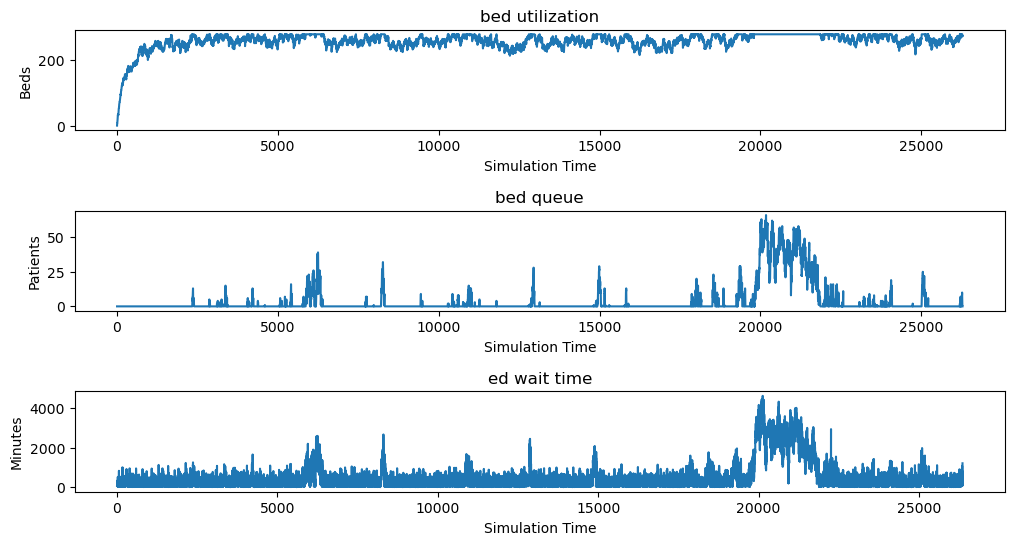

In [8]:
fig, ax = plt.subplots(3,1, figsize=(12,6))
plt.subplots_adjust(wspace = 0.2, hspace = 0.8)

ax[0].plot(bed_utalization)
ax[0].set_title("bed utilization")
ax[0].set_xlabel("Simulation Time")
ax[0].set_ylabel("Beds")

ax[1].plot(bed_queue)
ax[1].set_title("bed queue")
ax[1].set_xlabel("Simulation Time")
ax[1].set_ylabel("Patients")

ax[2].plot(ed_wait_time)
ax[2].set_title("ed wait time")
ax[2].set_xlabel("Simulation Time")
ax[2].set_ylabel("Minutes")

plt.show()

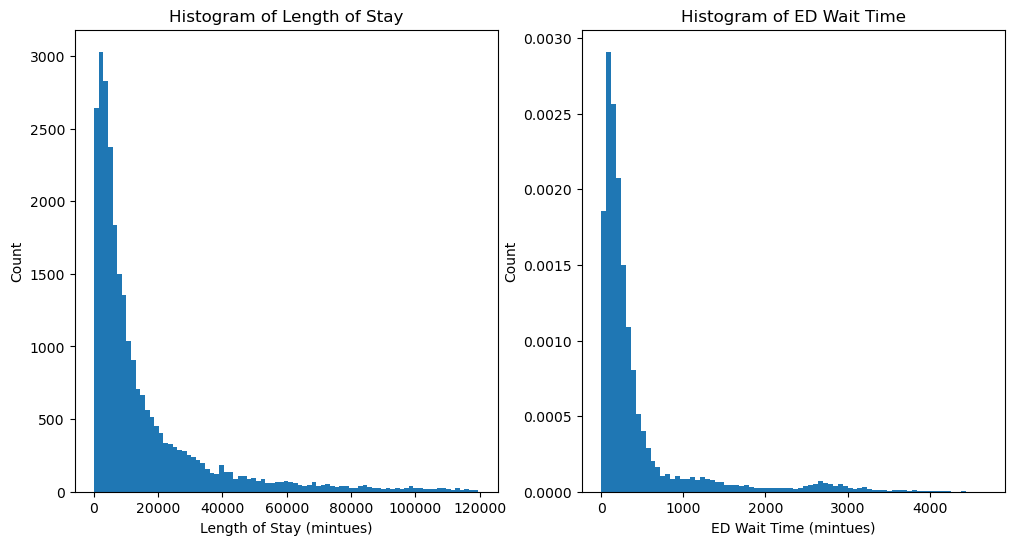

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
plt.subplots_adjust(wspace = 0.2, hspace = 0.8)

ax[0].hist(length_of_stay, bins=np.arange(min(length_of_stay), max(length_of_stay) + 1440, 1440))
ax[0].set_title('Histogram of Length of Stay')
ax[0].set_xlabel('Length of Stay (mintues)')
ax[0].set_ylabel('Count')

ax[1].hist(ed_wait_time, bins=np.arange(min(ed_wait_time), max(ed_wait_time) + 60, 60), density=True)
ax[1].set_title('Histogram of ED Wait Time')
ax[1].set_xlabel('ED Wait Time (mintues)')
ax[1].set_ylabel('Count')

plt.show()

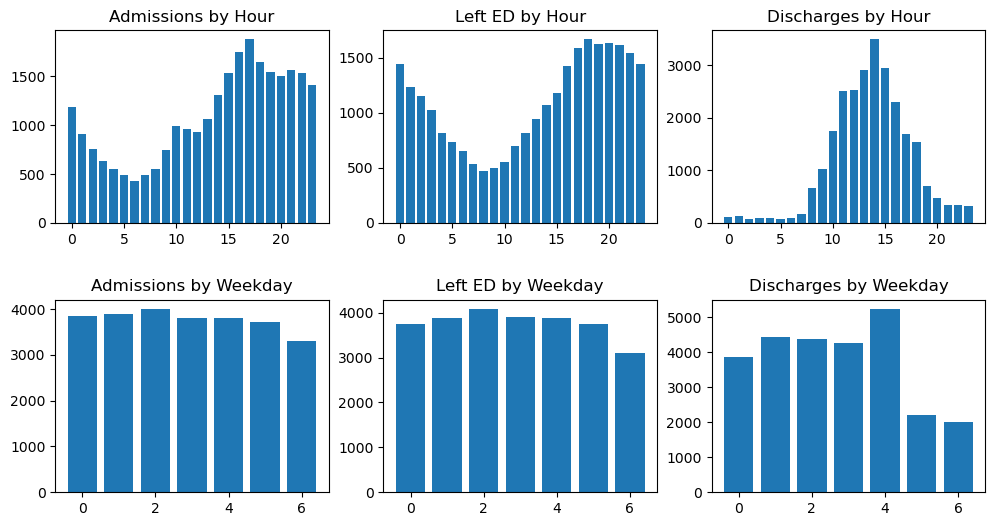

In [10]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)

ax[0,0].bar(np.unique(admit_hours, return_counts=True)[0],
            np.unique(admit_hours, return_counts=True)[1])
ax[0,0].set_title('Admissions by Hour')

ax[1,0].bar(np.unique(admit_weekdays, return_counts=True)[0],
            np.unique(admit_weekdays, return_counts=True)[1])
ax[1,0].set_title('Admissions by Weekday')

ax[0,1].bar(np.unique(left_ed_hours, return_counts=True)[0],
            np.unique(left_ed_hours, return_counts=True)[1])
ax[0,1].set_title('Left ED by Hour')

ax[1,1].bar(np.unique(left_ed_weekdays, return_counts=True)[0],
            np.unique(left_ed_weekdays, return_counts=True)[1])
ax[1,1].set_title('Left ED by Weekday')

ax[0,2].bar(np.unique(discharge_hours, return_counts=True)[0],
            np.unique(discharge_hours, return_counts=True)[1])
ax[0,2].set_title('Discharges by Hour')

ax[1,2].bar(np.unique(discharge_weekdays, return_counts=True)[0],
            np.unique(discharge_weekdays, return_counts=True)[1])
ax[1,2].set_title('Discharges by Weekday')

plt.show()